In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import colorama
from colorama import Fore, Back, Style


In [2]:
ball_data = pd.read_csv("/kaggle/input/ipl-2008-to-2021-all-match-dataset/IPL_Ball_by_Ball_2008_2022.csv")
match_data = pd.read_csv("/kaggle/input/ipl-2008-to-2021-all-match-dataset/IPL_Matches_2008_2022.csv")

In [3]:
#let us rename the features
match_data.columns = ['id','city','date','season','matchnumber','team1','team2','venue',
                      'tosswinner','tossdecision','superover','winningteam','wonby','margin',
                      'method','player_of_match','team1players','team2players','umpire1','umpire2']

ball_data.columns  = ['id','inning','over','ballnumber','batter','bowler','non_striker',
                      'extra_type','batsman_run','extras_run','total_runs','non_boundary',
                      'is_wicket', 'player_out','dismissal_kind','fielders_involved','battingteam']
colorsy= ['#0d293f', '#1f4956', '#185175', '#19618f', '#43779a', '#147eb0', '#2d93ca', '#58a9db', '#8ab5d8', '#9ccef0']

In [4]:
print(Back.GREEN+ Style.BRIGHT+'Match Data'+ Style.RESET_ALL)
match_data2 = match_data.drop(['team1players', 'team2players'], axis=1)
match_data2.head().style.set_properties(**{'background-color': '#cde6f7' ,'border': '1.3px solid black','color':'black','border-color': '#000000'})

Match Data


,id,city,date,season,matchnumber,team1,team2,venue,tosswinner,tossdecision,superover,winningteam,wonby,margin,method,player_of_match,umpire1,umpire2
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.000000,nan,HH Pandya,CB Gaffaney,Nitin Menon
1,1312199,Ahmedabad,2022-05-27,2022,Qualifier 2,Royal Challengers Bangalore,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,N,Rajasthan Royals,Wickets,7.000000,nan,JC Buttler,CB Gaffaney,Nitin Menon
2,1312198,Kolkata,2022-05-25,2022,Eliminator,Royal Challengers Bangalore,Lucknow Super Giants,"Eden Gardens, Kolkata",Lucknow Super Giants,field,N,Royal Challengers Bangalore,Runs,14.000000,nan,RM Patidar,J Madanagopal,MA Gough
3,1312197,Kolkata,2022-05-24,2022,Qualifier 1,Rajasthan Royals,Gujarat Titans,"Eden Gardens, Kolkata",Gujarat Titans,field,N,Gujarat Titans,Wickets,7.000000,nan,DA Miller,BNJ Oxenford,VK Sharma
4,1304116,Mumbai,2022-05-22,2022,70,Sunrisers Hyderabad,Punjab Kings,"Wankhede Stadium, Mumbai",Sunrisers Hyderabad,bat,N,Punjab Kings,Wickets,5.000000,nan,Harpreet Brar,AK Chaudhary,NA Patwardhan


In [5]:
print(Back.GREEN+ Style.BRIGHT+'Ball Data'+ Style.RESET_ALL)
ball_data.head().style.set_properties(**{'background-color': '#cde6f7' ,'border': '1.3px solid black','color':'black','border-color': '#000000'})

Ball Data


,id,inning,over,ballnumber,batter,bowler,non_striker,extra_type,batsman_run,extras_run,total_runs,non_boundary,is_wicket,player_out,dismissal_kind,fielders_involved,battingteam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,nan,0,0,0,0,0,nan,nan,nan,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,nan,nan,nan,Rajasthan Royals
2,1312200,1,0,3,JC Buttler,Mohammed Shami,YBK Jaiswal,nan,1,0,1,0,0,nan,nan,nan,Rajasthan Royals
3,1312200,1,0,4,YBK Jaiswal,Mohammed Shami,JC Buttler,nan,0,0,0,0,0,nan,nan,nan,Rajasthan Royals
4,1312200,1,0,5,YBK Jaiswal,Mohammed Shami,JC Buttler,nan,0,0,0,0,0,nan,nan,nan,Rajasthan Royals


In [6]:
#Let us add new derived features to the ball_data Dataframe...
ball_data['bowlingteam'] = ''
ball_data['first_batter'] = ''
ball_data['second_batter'] = ''

In [7]:
#In ball_data, we have two types of rows, which are to be treated as same for computing the partnership
#batter        non-striker
#-------------------------
#YBK Jaiswal   JC Buttler
#JC Buttler    YBK Jaiswal

#So we will be creating two new features as below and use them from partnership calculation
#first_batter second_batter
#--------------------------
#JC Buttler    YBK Jaiswal
#JC Buttler    YBK Jaiswal

ball_data['first_batter']  = ball_data.apply(lambda x: x['batter'] if x['batter']  <  x['non_striker'] else x['non_striker'], axis=1)
ball_data['second_batter'] = ball_data.apply(lambda x: x['non_striker'] if x['batter']  <  x['non_striker'] else x['batter'], axis=1)

In [8]:
#In ball_data,we have battingteam feature, let us add bowlingteam fature
#Let us add season info too..
ball_data = pd.merge(ball_data, match_data[['id','team1','team2','season']], how='left', on='id')
ball_data['bowlingteam'] = ball_data.apply(lambda x: x['team2'] if x['battingteam'] == x['team1'] else x['team1'], axis=1)

In [9]:
#In match_data, we have winningteam team feature and let us add win_against feature to it
match_data['win_against'] = match_data.apply(lambda x: x['team2'] if x['winningteam'] == x['team1'] else x['team1'], axis=1)

In [10]:
#To find Top 10 partnerships in IPL History
partnership_data=ball_data.groupby(['id','season','first_batter', 'second_batter','battingteam','bowlingteam'])\
                    .agg(partnership=('total_runs','sum')).reset_index()
top10_partnerships = partnership_data.sort_values(by='partnership',ascending=False).head(10)
top10_partnerships = top10_partnerships.sort_values(by='partnership',ascending=True)

fig = go.Figure(data=px.bar(x=top10_partnerships.battingteam, 
                            y=top10_partnerships.partnership,
                            color = top10_partnerships.first_batter+' & '+top10_partnerships.second_batter,
                            color_discrete_sequence=colorsy,
                            title='<b>Top 10 Partnerships in IPL</b>',
                            text = top10_partnerships.partnership,
                            height=500))
fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Batting Team</b>",
    yaxis_title="<b>Partnership</b>",
    legend_title_font_color="green"
)
fig.show()

In [11]:
#To find top partnerships per season
partnership_data['Rank'] = partnership_data.groupby('season')['partnership'].rank(ascending=False)
season_top_partnership=partnership_data[partnership_data['Rank']==1].sort_values('season')
#season_top_partnership

fig = go.Figure(data=px.bar(x=season_top_partnership.season, 
                            y=season_top_partnership.partnership,
                            color = season_top_partnership.first_batter+' & '+season_top_partnership.second_batter,
                            color_discrete_sequence=colorsy,
                            title='<b>Season-wise Top Partnerships in IPL</b>',
                            text = season_top_partnership.partnership,
                            height=500))
fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Season</b>",
    yaxis_title="<b>Partnership</b>",
    legend_title_font_color="green"
)
fig.show()

In [12]:
#Let us list the top 10 batsmen based on the total runs they made in IPL
top_batsman=ball_data.groupby(['batter']).agg(batsman_total=('batsman_run', 'sum')).reset_index()\
                .sort_values(by='batsman_total', ascending=False).head(10)

fig = px.pie(values=top_batsman.batsman_total, 
             names=top_batsman.batter,
             color_discrete_sequence=px.colors.sequential.Plasma)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='value+label')

fig.update_layout(title_text="<b>Top 10 Batsmen</b>",
                  title_font_family="Times New Roman",
                  title_font_color="red",
                  title_font_size=20,
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [13]:
print(Back.GREEN+ Style.BRIGHT+'Top 10 Batsmen Score Details'+ Style.RESET_ALL)
top_batsman_score = pd.DataFrame(columns=['batsman', 'fours', 'sixers', 'fifties', 'hundreds','heighest_score','total_runs', 'matches_played'])
for idx, row in top_batsman.iterrows():
    batsman_data = ball_data[ball_data['batter'] == row['batter']][['id', 'batter', 'batsman_run']]

    r4 = len(batsman_data[batsman_data['batsman_run'] == 4])
    r6 = len(batsman_data[batsman_data['batsman_run'] == 6])

    innings_score = batsman_data.groupby('id').agg(score=('batsman_run', 'sum')).reset_index()
    r50=len(innings_score[(innings_score['score'] >=50) & (innings_score['score'] < 100)])
    r100 = len(innings_score[innings_score['score'] >= 100])
    matches_played =  len(innings_score)
    heighest_score = innings_score['score'].max()


    top_batsman_score = top_batsman_score.append({'batsman': row['batter'], 'fours': r4, 'sixers': r6, 'fifties':r50,
                                                  'hundreds':r100, 'total_runs':row['batsman_total'],
                                                  'heighest_score':heighest_score,
                                                  'matches_played':matches_played},ignore_index=True)

top_batsman_score.style.set_properties(**{'background-color': '#cde6f7' ,'border': '1.3px solid black','color':'black','border-color': '#000000'})

Top 10 Batsmen Score Details


,batsman,fours,sixers,fifties,hundreds,heighest_score,total_runs,matches_played
0,V Kohli,581,219,45,5,113,6634,215
1,S Dhawan,701,137,47,2,106,6244,205
2,DA Warner,577,216,55,4,126,5883,162
3,RG Sharma,519,241,40,1,109,5881,221
4,SK Raina,506,204,39,1,100,5536,200
5,AB de Villiers,414,253,41,3,133,5181,170
6,CH Gayle,408,359,32,6,175,4997,141
7,MS Dhoni,346,229,24,0,84,4978,205
8,RV Uthappa,481,182,27,0,88,4954,197
9,KD Karthik,426,134,20,0,97,4377,207


In [14]:
# top_batsman_score

fig = make_subplots(cols=2,rows=3,
    vertical_spacing = 0.25, horizontal_spacing=.1,
                    subplot_titles=["No. of Sixers","No. of Fours",
                                    "No. of Half-Centuries","No. of Centuries",
                                   "Highest Scores", "Total Runs"],
                    y_title="<b>Top 10 Batsmen Run Details</b>"
    )
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.sixers,name="Highest Sixers"),row=1,col=1)
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.fours,name="Highest Fours"),row=1,col=2)
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.fifties,name="Highest Fifties"),row=2,col=1)
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.hundreds,name="Highest Hundreds"),row=2,col=2)
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.heighest_score,name="Highest Score"),row=3,col=1)
fig.add_trace(go.Bar(x=top_batsman_score.batsman,y=top_batsman_score.total_runs,name="Total Runs"),row=3,col=2)
fig.update_layout(height=800,width=1000, title_text="<b>Top 10 Batsmen Performance</b>",
                  title_font_family="Times New Roman",title_font_color="red",
                  title_font_size=20,)
fig.show()

In [15]:
highest_sixers = ball_data[ball_data['batsman_run']==6].groupby('batter').agg(six_count=('batsman_run', 'count'))\
      .reset_index().sort_values(by='six_count', ascending=False).head(10)

fig = go.Figure(data=px.bar(x=highest_sixers.batter, 
                            y=highest_sixers.six_count,
                            color = highest_sixers.six_count,
                            color_discrete_sequence=px.colors.sequential.Oranges,
                            title='<b>Top 10 Six-hitters in IPL</b>',
                            text = highest_sixers.six_count,
                            height=400))

fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Batsman</b>",
    yaxis_title="<b>No. of Sixers</b>",
    legend_title_font_color="green"
)

fig.show()

In [16]:
highest_fours = ball_data[ball_data['batsman_run']==4].groupby('batter').agg(four_count=('batsman_run', 'count'))\
      .reset_index().sort_values(by='four_count', ascending=False).head(10)
# highest_fours
fig = go.Figure(data=px.bar(x=highest_fours.batter, 
                            y=highest_fours.four_count,
                            color = highest_fours.four_count,
                            color_discrete_sequence=px.colors.sequential.Oranges,
                            title='<b>Top 10 Four-hitters in IPL</b>',
                            text = highest_fours.four_count,
                            height=400))
fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Batsman</b>",
    yaxis_title="<b>No. of Fours</b>",
    legend_title_font_color="green"
)

fig.show()

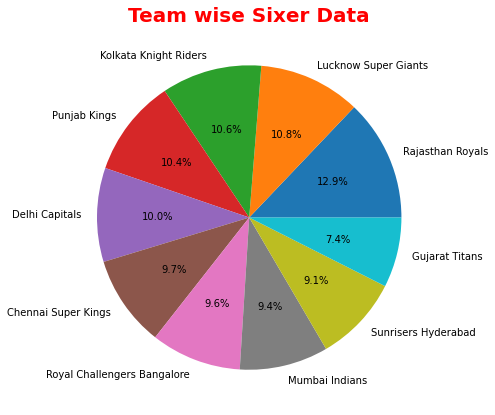

In [17]:
sixer_df=ball_data['battingteam'][(ball_data['batsman_run']==6) & (ball_data['season']=='2022')].reset_index()
sixer_df=sixer_df.groupby('battingteam').agg(sixer_count=('battingteam','count')).reset_index()
sixer_df=sixer_df.sort_values('sixer_count', ascending=False)

fig = plt.figure(figsize =(10, 7))
plt.pie(sixer_df['sixer_count'], labels = sixer_df['battingteam'], autopct='%0.1f%%')
plt.title("Team wise Sixer Data", fontsize=20, color='red', fontweight='bold')
plt.show()

In [18]:
df1 = ball_data[['batter','bowlingteam', 'batsman_run']][ball_data['batter'].isin(top_batsman['batter'])]\
            .groupby(['batter', 'bowlingteam']).agg(batter_score=('batsman_run', 'sum')).reset_index()

print(Back.GREEN+ Style.BRIGHT+'Runs scored by top batsmen against opponent teams'+ Style.RESET_ALL)
df2 = df1.pivot_table('batter_score', ['bowlingteam'], 'batter')
df2.style.background_gradient(axis=None, low=0.75, high=1.0) 

Runs scored by top batsmen against opponent teams


batter,AB de Villiers,CH Gayle,DA Warner,KD Karthik,MS Dhoni,RG Sharma,RV Uthappa,S Dhawan,SK Raina,V Kohli
bowlingteam,,,,,,,,,,
Chennai Super Kings,532.000000,395.000000,558.000000,647.000000,nan,770.000000,547.000000,1029.000000,nan,979.000000
Deccan Chargers,153.000000,67.000000,226.000000,164.000000,281.000000,175.000000,138.000000,118.000000,310.000000,306.000000
Delhi Capitals,179.000000,122.000000,182.000000,154.000000,160.000000,211.000000,155.000000,28.000000,154.000000,164.000000
Delhi Daredevils,409.000000,383.000000,268.000000,378.000000,487.000000,701.000000,587.000000,522.000000,507.000000,761.000000
Gujarat Lions,233.000000,100.000000,336.000000,nan,83.000000,82.000000,111.000000,127.000000,nan,283.000000
Gujarat Titans,nan,nan,nan,4.000000,7.000000,43.000000,3.000000,97.000000,nan,131.000000
Kings XI Punjab,710.000000,797.000000,906.000000,557.000000,595.000000,671.000000,756.000000,733.000000,822.000000,681.000000
Kochi Tuskers Kerala,54.000000,44.000000,16.000000,69.000000,23.000000,nan,31.000000,4.000000,69.000000,50.000000
Kolkata Knight Riders,522.000000,700.000000,1018.000000,366.000000,551.000000,1020.000000,283.000000,810.000000,829.000000,786.000000


In [19]:
top_batsman =['RG Sharma', 'S Dhawan', 'SK Raina', 'V Kohli'] 
top_batsman_runs=ball_data[ball_data['batter'].isin(top_batsman)].groupby(['season','batter'])\
    .agg(batsman_total=('batsman_run', 'sum')).reset_index()\
    .sort_values(by=['season','batsman_total'], ascending=False)

fig = px.line(top_batsman_runs, x='season', y='batsman_total', color='batter', symbol="batter",template='simple_white')
fig.update_layout(hovermode="x unified")
fig.update_xaxes(categoryorder='category ascending')
fig.update_yaxes(showgrid=True)
fig.update_traces(line=dict(width=3.0))

fig.update_layout(
    title='<b>Batter Performance across seasons</b>',
    font_family="Courier New",
    title_font_family="Courier New",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Season</b>",
    yaxis_title="<b>Runs</b>",
    legend_title='<b>Batter</b>',
    legend_title_font_color="red",
    plot_bgcolor = '#FFFFFF'
)

fig.show()

In [20]:
print(Back.GREEN+ Style.BRIGHT+'Top 10 wicket takers'+ Style.RESET_ALL)
dismissal_list = ['caught','caught and bowled','bowled','stumped','hit wicket']
top10_bowlers=ball_data[(ball_data['is_wicket']==1) & (ball_data['dismissal_kind'].isin(dismissal_list))]\
                            .groupby('bowler').agg(wicket_count=('is_wicket', 'count'))\
                            .sort_values('wicket_count', ascending=False).reset_index().head(10)
top10_bowlers.style.background_gradient("Blues")

Top 10 wicket takers


,bowler,wicket_count
0,DJ Bravo,175
1,SL Malinga,159
2,YS Chahal,153
3,A Mishra,152
4,B Kumar,145
5,Harbhajan Singh,142
6,PP Chawla,140
7,R Ashwin,140
8,JJ Bumrah,132
9,SP Narine,130


In [21]:
print(Back.GREEN+ Style.BRIGHT+'Bowler performance(wicket count) against opponent teams'+ Style.RESET_ALL)
bowler_team = ball_data[(ball_data['is_wicket']==1) & (ball_data['dismissal_kind'].isin(dismissal_list))\
                            & (ball_data['bowler'].isin(top10_bowlers['bowler']))]\
                            .groupby(['bowler','battingteam']).agg(wkt_count=('is_wicket', 'count'))\
                            .reset_index()

bowler_team = bowler_team.pivot_table('wkt_count', ['battingteam'], 'bowler')
bowler_team.style.background_gradient("Blues")

Bowler performance(wicket count) against opponent teams


bowler,A Mishra,B Kumar,DJ Bravo,Harbhajan Singh,JJ Bumrah,PP Chawla,R Ashwin,SL Malinga,SP Narine,YS Chahal
battingteam,,,,,,,,,,
Chennai Super Kings,12.000000,10.000000,5.000000,21.000000,11.000000,17.000000,6.000000,28.000000,16.000000,16.000000
Deccan Chargers,11.000000,2.000000,7.000000,9.000000,nan,7.000000,4.000000,18.000000,2.000000,nan
Delhi Capitals,nan,8.000000,11.000000,3.000000,13.000000,2.000000,3.000000,1.000000,2.000000,4.000000
Delhi Daredevils,6.000000,5.000000,11.000000,20.000000,8.000000,18.000000,17.000000,18.000000,13.000000,12.000000
Gujarat Lions,2.000000,12.000000,nan,3.000000,5.000000,2.000000,nan,3.000000,nan,7.000000
Gujarat Titans,nan,2.000000,3.000000,nan,nan,nan,nan,nan,nan,2.000000
Kings XI Punjab,20.000000,18.000000,20.000000,20.000000,18.000000,14.000000,14.000000,20.000000,26.000000,20.000000
Kochi Tuskers Kerala,1.000000,nan,1.000000,nan,nan,nan,3.000000,2.000000,nan,nan
Kolkata Knight Riders,14.000000,30.000000,20.000000,15.000000,18.000000,10.000000,21.000000,20.000000,nan,20.000000


In [22]:
#Let us list the Hattricks scored in IPL so far
wkt_bowlers= ball_data[ball_data['is_wicket']==1].groupby(['id','bowler']).agg(wkt_count=('is_wicket', 'count')).reset_index()
hattricks = pd.DataFrame(columns= ['bowler'])
for bow_index, bow_row in wkt_bowlers[wkt_bowlers['wkt_count']>=3][['id','bowler']].iterrows():
    wkt_cnt=0
    for ball_index, ball_row in ball_data[(ball_data['id']==bow_row['id']) &
                                          (ball_data['bowler']==bow_row['bowler'])]\
                                            .sort_values(by =(['id','inning','over','ballnumber'])).iterrows():

        if ball_row['is_wicket']==1 and ball_row['dismissal_kind'] not in ['run out','retired hurt','obstructing the field'] :
            wkt_cnt +=1
            if wkt_cnt == 3: 
                wkt_cnt = 0
                hattricks = hattricks.append({'bowler' : ball_row['bowler']}, ignore_index = True)
        else:wkt_cnt =0
            
hattricks = hattricks.groupby('bowler').agg(hatk_count=('bowler', 'count')).reset_index()
# hattricks

fig = go.Figure(data=px.bar(x=hattricks.bowler, 
                            y=hattricks.hatk_count,
                            color = hattricks.bowler,
                            color_discrete_sequence=px.colors.sequential.Plasma,
                            title='<b>Hattricks in IPL</b>',
                            text = hattricks.hatk_count,
                            height=500))
fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Bowler</b>",
    yaxis_title="<b>Hattricks</b>",
    legend_title_font_color="green"
)

fig.show()

In [23]:
pom_df=match_data.groupby(['season','player_of_match']).agg(pom_count=('player_of_match','count')).reset_index()
pom_df


pom_df['Rank'] = pom_df.groupby('season')['pom_count'].rank(ascending=False)
season_top_pom=pom_df[pom_df['Rank']==1].sort_values('season')
#season_top_pom

fig = go.Figure(data=px.bar(x=season_top_pom.season, 
                            y=season_top_pom.pom_count,
                            color = season_top_pom.player_of_match,
                            color_discrete_sequence=colorsy,
                            title='<b>Top 10 Player-of-the-Match winners in IPL</b>',
                            text = season_top_pom.pom_count,
                            height=500))

fig.update_layout(
    font_family="Courier New",
    title_font_family="Times New Roman",
    title_font_color="red",
    title_font_size=20,
    xaxis_title="<b>Season</b>",
    yaxis_title="<b>No. of PoMs</b>",
    legend_title_font_color="green"
)

fig.show()

In [24]:
full_data = pd.merge(match_data, ball_data, how='left', on='id')

inning_data = full_data[['id', 'inning', 'total_runs']]\
                        [(full_data['superover']=='N') & (full_data['method'] !='D/L')]\
                        .groupby(['id', 'inning']).agg(inning_score=('total_runs','sum')).reset_index()
inning_data = inning_data.pivot_table('inning_score', ['id'], 'inning').reset_index()
inning_data.rename(columns = {1:'first_inning', 2:'second_inning'}, inplace=True)

match_scores = pd.merge(match_data, inning_data, how='left', on='id')

chased_matches=match_scores[match_scores['wonby']=='Wickets'].sort_values('first_inning', ascending=False)
defended_matches=match_scores[match_scores['wonby']=='Runs'].sort_values('first_inning', ascending=True)

print(Back.GREEN+ Style.BRIGHT+ 'Top 5 High scores successfully chased:' + Style.RESET_ALL)
for idx, row in chased_matches.head().iterrows():
    print(Fore.RED+ Style.BRIGHT+  row['team2'] + Style.RESET_ALL \
      + ' sucessfully chased target of ' \
      + Back.CYAN+ Style.BRIGHT+ Style.BRIGHT + str(row['first_inning']) + Style.RESET_ALL \
      + ' against '\
      + Fore.RED + Style.BRIGHT+ row['team1'] + Style.RESET_ALL
      + 'in season ' 
      + Fore.BLUE + Style.BRIGHT+ row['season'] + Style.RESET_ALL )

Top 5 High scores successfully chased:
Rajasthan Royals sucessfully chased target of 223.0 against Kings XI Punjabin season 2020/21
Mumbai Indians sucessfully chased target of 218.0 against Chennai Super Kingsin season 2021
Rajasthan Royals sucessfully chased target of 214.0 against Deccan Chargersin season 2007/08
Lucknow Super Giants sucessfully chased target of 210.0 against Chennai Super Kingsin season 2022
Gujarat Lions sucessfully chased target of 208.0 against Delhi Daredevilsin season 2017


In [25]:
print(Back.GREEN+ Style.BRIGHT+ 'Top 5 Low scores successfully defended:' + Style.RESET_ALL)
for idx, row in defended_matches.head().iterrows():
    print(Fore.RED+ Style.BRIGHT+  row['team1'] + Style.RESET_ALL \
      + ' sucessfully defended target of ' \
      + Back.CYAN + Style.BRIGHT+ str(row['first_inning']) + Style.RESET_ALL \
      + ' against '\
      + Fore.RED + Style.BRIGHT+ row['team2'] + Style.RESET_ALL
      + 'in season ' 
      + Fore.BLUE + Style.BRIGHT+ row['season'] + Style.RESET_ALL )

Top 5 Low scores successfully defended:
Royal Challengers Bangalore sucessfully defended target of 106.0 against Chennai Super Kingsin season 2013
Kings XI Punjab sucessfully defended target of 106.0 against Royal Challengers Bangalorein season 2015
Chennai Super Kings sucessfully defended target of 116.0 against Kings XI Punjabin season 2009
Sunrisers Hyderabad sucessfully defended target of 118.0 against Mumbai Indiansin season 2018
Kings XI Punjab sucessfully defended target of 119.0 against Mumbai Indiansin season 2009


In [26]:
print(Back.GREEN+ Style.BRIGHT+ 'Match win with highest run margin:' + Style.RESET_ALL)
for idx, row in match_data[['winningteam','win_against', 'margin', 'season']]\
    [match_data['margin'] == match_data['margin'].max()].iterrows():
    print(Fore.RED+ Style.BRIGHT+  row['winningteam'] + Style.RESET_ALL \
      + ' won with highest ever margin of ' \
      + Back.CYAN + Style.BRIGHT+ str(row['margin']) + Style.RESET_ALL \
      + ' against '\
      + Fore.RED + Style.BRIGHT+ row['win_against'] + Style.RESET_ALL
      + 'in season ' 
      + Fore.BLUE + Style.BRIGHT+ row['season'] + Style.RESET_ALL )

Match win with highest run margin:
Mumbai Indians won with highest ever margin of 146.0 against Delhi Daredevilsin season 2017


In [27]:
print(Back.GREEN+ Style.BRIGHT+'Highest win margin in each season:'+ Style.RESET_ALL)
margin_df= match_data.groupby('season').agg(max_margin=('margin', 'max')).reset_index()
for idx1, row1 in margin_df[[ 'season', 'max_margin']].iterrows():
    for idx, row in match_data[['winningteam','win_against', 'margin', 'season']]\
            [(match_data['margin'] == row1['max_margin']) & (match_data['season'] == row1['season'])]\
            .iterrows():
        print(Fore.RED+ Style.BRIGHT+  row['winningteam'] + Style.RESET_ALL \
          + ' won with highest margin of ' \
          + Back.CYAN + Style.BRIGHT+ str(row['margin']) + Style.RESET_ALL \
          + ' against '\
          + Fore.RED + Style.BRIGHT+ row['win_against'] + Style.RESET_ALL
          + 'in season ' 
          + Fore.BLUE + Style.BRIGHT +row['season'] + Style.RESET_ALL )

Highest win margin in each season:
Kolkata Knight Riders won with highest margin of 140.0 against Royal Challengers Bangalorein season 2007/08
Mumbai Indians won with highest margin of 92.0 against Kolkata Knight Ridersin season 2009
Chennai Super Kings won with highest margin of 92.0 against Royal Challengers Bangalorein season 2009
Mumbai Indians won with highest margin of 98.0 against Delhi Daredevilsin season 2009/10
Kings XI Punjab won with highest margin of 111.0 against Royal Challengers Bangalorein season 2011
Chennai Super Kings won with highest margin of 86.0 against Delhi Daredevilsin season 2012
Royal Challengers Bangalore won with highest margin of 130.0 against Pune Warriorsin season 2013
Chennai Super Kings won with highest margin of 93.0 against Delhi Daredevilsin season 2014
Royal Challengers Bangalore won with highest margin of 138.0 against Kings XI Punjabin season 2015
Royal Challengers Bangalore won with highest margin of 144.0 against Gujarat Lionsin season 2016
M

In [28]:
print(Back.GREEN+ Style.BRIGHT+'Head on head encounters : Team vs Team (win count on each other)'+ Style.RESET_ALL)
df1=match_data[['winningteam','win_against']].groupby(['winningteam','win_against']).agg(win_count=('win_against','count'))
df2=df1.pivot_table('win_count', ['winningteam'], 'win_against')
df2.style.background_gradient("plasma")

Head on head encounters : Team vs Team (win count on each other)


win_against,Chennai Super Kings,Deccan Chargers,Delhi Capitals,Delhi Daredevils,Gujarat Lions,Gujarat Titans,Kings XI Punjab,Kochi Tuskers Kerala,Kolkata Knight Riders,Lucknow Super Giants,Mumbai Indians,Pune Warriors,Punjab Kings,Rajasthan Royals,Rising Pune Supergiant,Rising Pune Supergiants,Royal Challengers Bangalore,Sunrisers Hyderabad
winningteam,,,,,,,,,,,,,,,,,,
Chennai Super Kings,nan,6.000000,5.000000,12.000000,nan,nan,14.000000,1.000000,17.000000,nan,14.000000,4.000000,1.000000,15.000000,nan,nan,19.000000,13.000000
Deccan Chargers,4.000000,nan,nan,4.000000,nan,nan,3.000000,1.000000,2.000000,nan,4.000000,3.000000,nan,2.000000,nan,nan,6.000000,nan
Delhi Capitals,4.000000,nan,nan,nan,nan,nan,2.000000,nan,6.000000,nan,4.000000,nan,4.000000,6.000000,nan,nan,4.000000,6.000000
Delhi Daredevils,6.000000,7.000000,nan,nan,3.000000,nan,9.000000,1.000000,8.000000,nan,11.000000,3.000000,nan,7.000000,2.000000,nan,6.000000,4.000000
Gujarat Lions,nan,nan,nan,1.000000,nan,nan,2.000000,nan,3.000000,nan,2.000000,nan,nan,nan,1.000000,2.000000,2.000000,nan
Gujarat Titans,2.000000,nan,1.000000,nan,nan,nan,nan,nan,1.000000,2.000000,nan,nan,1.000000,3.000000,nan,nan,1.000000,1.000000
Kings XI Punjab,9.000000,7.000000,2.000000,13.000000,2.000000,nan,nan,1.000000,9.000000,nan,12.000000,3.000000,nan,9.000000,1.000000,1.000000,14.000000,5.000000
Kochi Tuskers Kerala,1.000000,nan,nan,1.000000,nan,nan,nan,nan,2.000000,nan,1.000000,nan,nan,1.000000,nan,nan,nan,nan
Kolkata Knight Riders,9.000000,7.000000,3.000000,13.000000,1.000000,nan,18.000000,nan,nan,nan,9.000000,4.000000,2.000000,14.000000,1.000000,2.000000,16.000000,15.000000


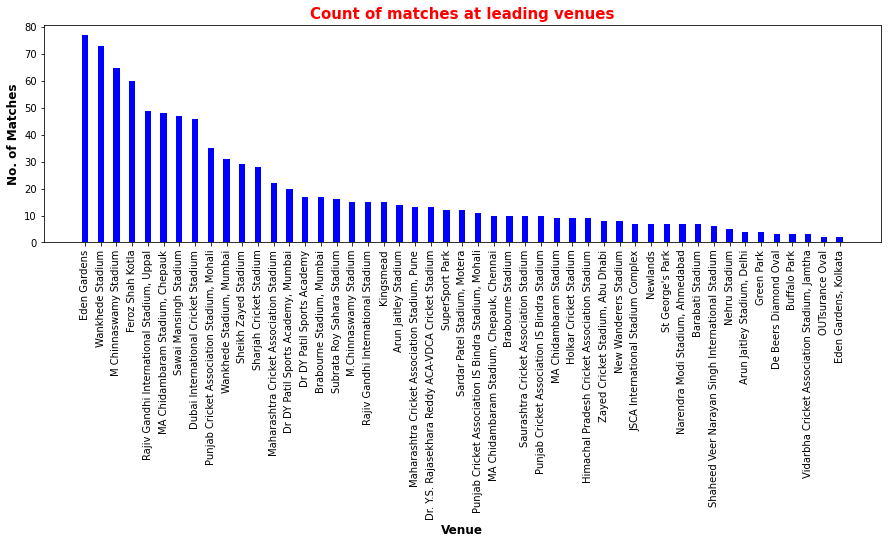

In [29]:
venue_df=match_data.groupby('venue').agg(match_count=('venue', 'count')).reset_index().sort_values('match_count', ascending=False)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(4)
plt.bar(venue_df['venue'], venue_df['match_count'], color ='blue',width = 0.4)
plt.xlabel("Venue", fontsize=12, fontweight='bold') 
plt.ylabel("No. of Matches", fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.title("Count of matches at leading venues", fontsize=15, color='red', fontweight='bold') 
plt.show()